In [183]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

This serves as a baseline for the clustering of movies. We create a graph containing all the movies as nodes, in which distances between nodes depend on how similar the corpus that describes each movie is between all nodes/movies. Spectral clustering is performed on the graph and, at the end, we generate a word cloud for each cluster of movies.

In [98]:
df = pd.read_csv("../data/metadata/movies_metadata.csv")

In [99]:
def cosine_similarity(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
 
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0 
    
    return np.dot(a, b) / (norm_a * norm_b)

In [100]:
def cosine_similarity_numpy(X):
    
    # Normalize rows to unit length
    X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)

    S = X_norm @ X_norm.T

   

    # clip tiny negative values due to floating point errors
    np.clip(S, -1.0, 1.0, out=S)
    
    return S

Only consider the year of release

In [164]:
df['Released'] = df['Released'].str[-4:]

In [165]:
metadata = {}
attributes = ['Title', 'Released', 'Director', 'Genre']

for _, row in df.iterrows():
    key = row['ID']

    document = ' '.join(str(row[attr]).replace("-", "").replace(":", "") for attr in attributes)

    metadata[key] = document

metadata

{'tt0076759': 'Star Wars Episode IV  A New Hope 1977 George Lucas Action, Adventure, Fantasy',
 'tt0054215': 'Psycho 1960 Alfred Hitchcock Drama, Horror, Mystery',
 'tt0062622': '2001 A Space Odyssey 1968 Stanley Kubrick Adventure, SciFi',
 'tt0082158': 'Chariots of Fire 1982 Hugh Hudson Biography, Drama, Sport',
 'tt0075148': 'Rocky 1976 John G. Avildsen Drama, Sport',
 'tt0060196': 'The Good, the Bad and the Ugly 1967 Sergio Leone Adventure, Drama, Western',
 'tt0055928': 'Dr. No 1962 Terence Young Action, Adventure, Thriller',
 'tt0180093': 'Requiem for a Dream 2000 Darren Aronofsky Drama',
 'tt0082971': 'Raiders of the Lost Ark 1981 Steven Spielberg Action, Adventure',
 'tt0052520': 'The Twilight Zone 1959 nan Drama, Fantasy, Horror',
 'tt0073195': 'Jaws 1975 Steven Spielberg Adventure, Horror, Thriller',
 'tt0056172': 'Lawrence of Arabia 2013 David Lean Adventure, Biography, Drama',
 'tt0325980': 'Pirates of the Caribbean The Curse of the Black Pearl 2003 Gore Verbinski Action, Ad

Compute TF-IDF vectors for each movie

In [ ]:
documents = list(metadata.values())
movie_ids = list(metadata.keys())

vectorizer = TfidfVectorizer(
    lowercase=True,
    # keep years, names, etc.
    token_pattern=r'(?u)\b\w+\b',  
    # unigrams
    ngram_range=(1, 1)             
)

tfidf_matrix = vectorizer.fit_transform(documents)
tfidf_matrix = tfidf_matrix.toarray()

tfidf_df = pd.DataFrame(
    tfidf_matrix,
    index=movie_ids,
    columns=vectorizer.get_feature_names_out()
)


print("TF-IDF Matrix:")
print(tfidf_df.round(3))

TF-IDF Matrix:
             1  13th  1935  1938  1939  1940  1941  1942  1947  1948  ...  \
tt0076759  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0054215  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0062622  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0082158  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0075148  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
tt0053125  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0082340  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0069704  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0363771  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
tt0120815  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

            york  you  young  zemeckis  zhivago  zone  zorba

Compute cosine similarity between movies and transform them to distances. 

In [ ]:
similarity_matrix = cosine_similarity(tfidf_matrix)

cosine_dist = 1 - similarity_matrix
# make sure the diagonal is 0 and avoid floating point errors
np.fill_diagonal(cosine_dist, 0)  


Generate graph with distances represented in edges between nodes.

In [ ]:
G = nx.Graph()

for movie in movie_ids:
    G.add_node(movie, label=movie)

n_movies = len(movie_ids)
for i in range(n_movies):
    for j in range(i + 1, n_movies): 
        distance = cosine_dist[i, j]
        # Skip zero distances (the movie itself)
        if distance > 0:  
            G.add_edge(movie_ids[i], movie_ids[j], weight=distance)


print(f"Number of nodes (movies): {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes (movies): 201
Number of edges: 20100


Convert distances to affinity

In [ ]:
def distance_to_affinity(dist_matrix, sigma=1.0):
    # RBF (Gaussian) kernel: sim(i,j) = exp(-dist(i,j)^2 / (2*sigma^2))
    squared_dists = dist_matrix ** 2
    affinity = np.exp(-squared_dists / (2.0 * sigma ** 2))
    # No self-loops
    np.fill_diagonal(affinity, 0)  
    return affinity

In [ ]:
sigma = 1.0 
# Compute the median of cosine distances as the scale parameter
sigma = np.median(cosine_dist[cosine_dist > 0])
affinity_matrix = distance_to_affinity(cosine_dist, sigma=sigma)
sigma

np.float64(0.9808999063168786)

Spectral Clustering

In [ ]:
n_clusters = 6  # Try 2, 3, etc.
spectral = SpectralClustering(
    n_clusters=n_clusters,
    affinity='precomputed',   
    assign_labels='kmeans',   
    random_state=42
)

labels = spectral.fit_predict(affinity_matrix)

# Add the results to a DataFrame
results = pd.DataFrame({
    'movie': movie_ids,
    'cluster': labels
})

results

,movie,cluster
0,tt0076759,0
1,tt0054215,4
2,tt0062622,5
3,tt0082158,2
4,tt0075148,2
...,...,...
196,tt0053125,4
197,tt0082340,5
198,tt0069704,0
199,tt0363771,3


Collect the corpus from all the movies inside each cluster and associate it to the respective cluster.

In [192]:
labels = labels.tolist()

cluster_collection = {}
freqs_labels = {}
for l in range (n_clusters):
    freqs_labels[int(l)] = []
    cluster_collection[int(l)] = []


for i, m_id in enumerate(movie_ids):
    cluster_collection[labels[i]].append(metadata[m_id])


for k in cluster_collection.keys():
    cluster_collection[k] = " ".join(cluster_collection[k])



Tokenize the corpus for each cluster and compute the frequency of each token

In [ ]:
word2count = {}

PUNCT_EXCEPT_APOSTROPHE = str.maketrans(
    '', '',                     # No characters to keep / replace
    string.punctuation.replace("'", '')   # Delete everything except '
)

for data in cluster_collection.items():

    label = data[0]
    corpus = data[1]

    no_punct = corpus.translate(PUNCT_EXCEPT_APOSTROPHE)

    words = nltk.word_tokenize(no_punct)


    for word in words:
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

    stop_words = set(stopwords.words('english'))

    filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}

    freqs_labels[label] = filtered_word2count

print(freqs_labels)

{0: {'Star': 2, 'Wars': 1, 'Episode': 1, 'IV': 2, 'A': 1, 'New': 1, 'Hope': 1, '1977': 1, 'George': 2, 'Lucas': 2, 'Action': 13, 'Adventure': 29, 'Fantasy': 9, 'Ghostbusters': 1, '1984': 2, 'Ivan': 1, 'Reitman': 1, 'Comedy': 33, 'Singin': 1, "'": 1, 'Rain': 1, '1952': 1, 'Stanley': 2, 'Donen': 1, 'Gene': 1, 'Kelly': 1, 'Musical': 2, 'Romance': 7, 'Back': 1, 'Future': 1, '1985': 1, 'Robert': 1, 'Zemeckis': 1, 'SciFi': 4, 'Batman': 1, '1989': 2, 'Tim': 4, 'Burton': 4, 'Robin': 1, 'Hood': 1, 'Prince': 1, 'Thieves': 1, '1991': 3, 'Kevin': 2, 'Reynolds': 1, 'Drama': 7, 'Austin': 1, 'Powers': 1, 'International': 1, 'Man': 1, 'Mystery': 1, '1997': 4, 'Jay': 1, 'Roach': 1, 'Avatar': 1, '2009': 2, 'James': 3, 'Cameron': 1, 'Grease': 1, '1978': 1, 'Randal': 1, 'Kleiser': 1, 'The': 6, 'Addams': 1, 'Family': 6, 'Barry': 3, 'Sonnenfeld': 2, 'National': 1, 'Lampoon': 1, "'s": 2, 'Vacation': 1, '1983': 3, 'Harold': 1, 'Ramis': 1, 'Lady': 1, 'Tramp': 1, '1955': 1, 'Clyde': 1, 'Geronimi': 1, 'Wilfred':

Plot Word Clouds for each cluster

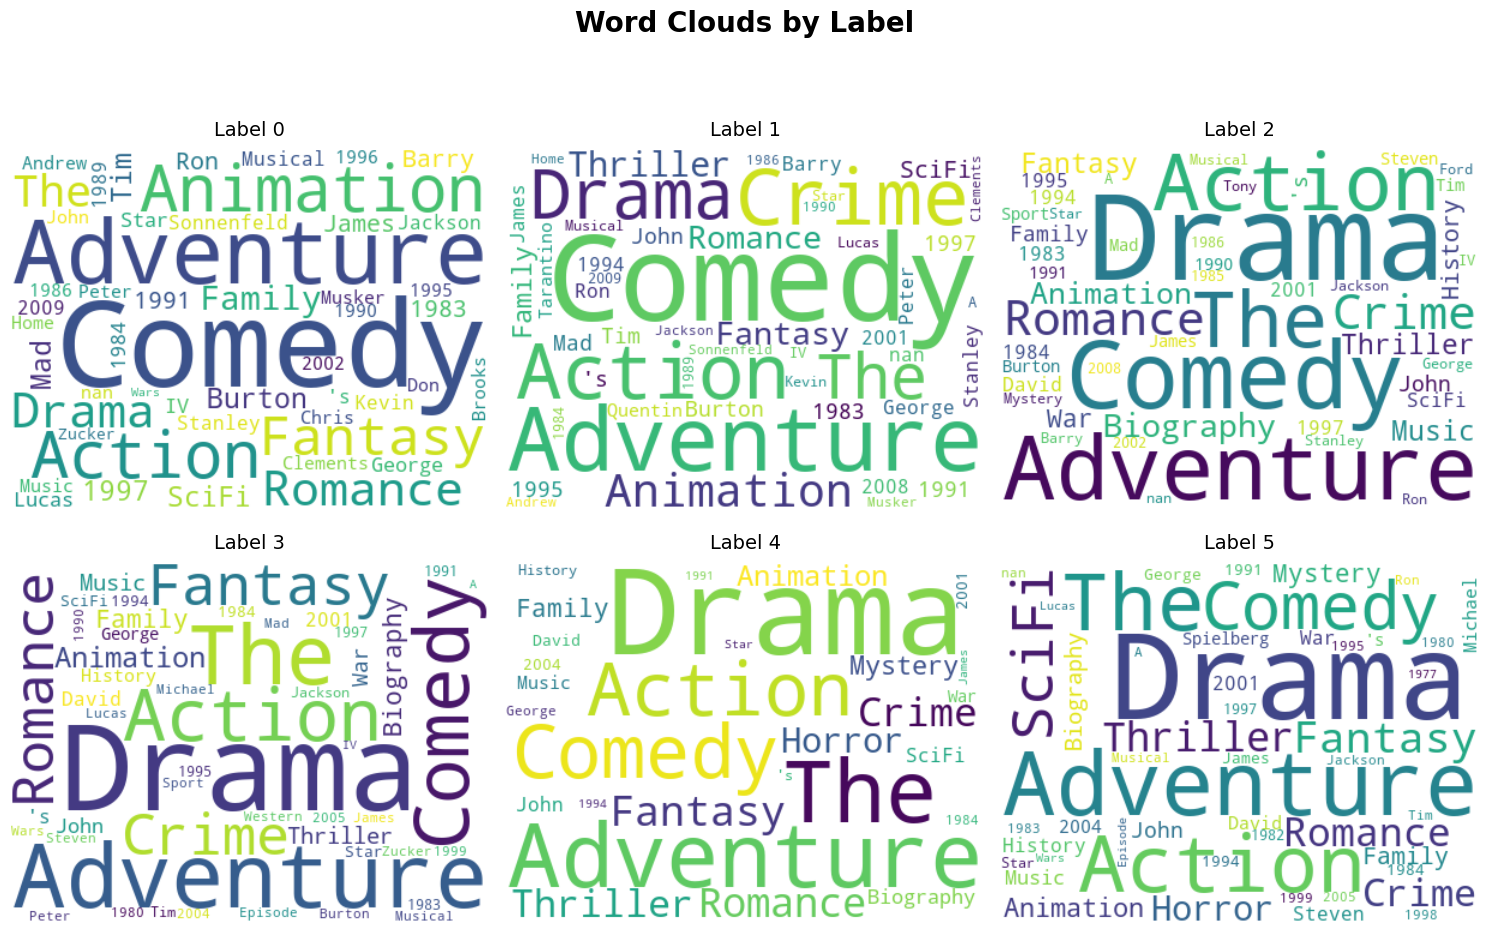

In [ ]:
cols = 3
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
fig.suptitle('Word Clouds by Label', fontsize=20, fontweight='bold')

axes = axes.flatten()

for idx, (label, freq_dict) in enumerate(freqs_labels.items()):
    ax = axes[idx]
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        max_words=50,
        min_font_size=10,
        max_font_size=100,
        relative_scaling=0.5,
        contour_width=1,
        contour_color='gray'
    ).generate_from_frequencies(freq_dict)
    
    # Plot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Label {label}', fontsize=14, pad=10)
    ax.axis('off')

# Hide unused subplots (if plots <6)
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()